In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt

## 1. Data importing and EDA a little. 

In [3]:
df = pd.read_csv('cafe_transactions.csv')
df

,Transaction ID,Sender Account ID,Receiver Account ID,Transaction Amount,Transaction Type,Timestamp,Device Used,Category
0,TXN5555622598,ACC82547,ACC14994,1124.76,deposit,2025-06-26 20:56:00,mobile,sales
1,TXN1661259342,ACC37330,ACC14994,1866.36,deposit,2025-06-03 17:50:00,mobile,sales
2,TXN6102878441,ACC39093,ACC14994,1020.28,deposit,2025-06-25 18:31:00,mobile,sales
3,TXN9159636380,ACC76575,ACC14994,1239.85,deposit,2025-06-22 16:29:00,mobile,sales
4,TXN8843546556,ACC14994,ACC14994,19001.60,transfer,2025-06-11 22:40:00,desktop,internal
...,...,...,...,...,...,...,...,...
9995,TXN3057599866,ACC38373,ACC14994,1750.68,deposit,2025-06-02 17:41:00,mobile,sales
9996,TXN8049041369,ACC83497,ACC14994,1012.91,deposit,2025-06-25 19:07:00,mobile,sales
9997,TXN7651443054,ACC76416,ACC14994,1201.49,deposit,2025-06-22 18:49:00,mobile,sales
9998,TXN8896763535,ACC85661,ACC14994,1468.15,deposit,2025-06-28 18:51:00,mobile,sales


In [4]:
print(df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Transaction ID       10000 non-null  object 
 1   Sender Account ID    10000 non-null  object 
 2   Receiver Account ID  10000 non-null  object 
 3   Transaction Amount   10000 non-null  float64
 4   Transaction Type     10000 non-null  object 
 5   Timestamp            10000 non-null  object 
 6   Device Used          10000 non-null  object 
 7   Category             10000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB
None        Transaction Amount
count        10000.000000
mean          2471.375082
std           3448.833086
min           1000.020000
25%           1272.672500
50%           1550.190000
75%           1837.855000
max          25000.000000


In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

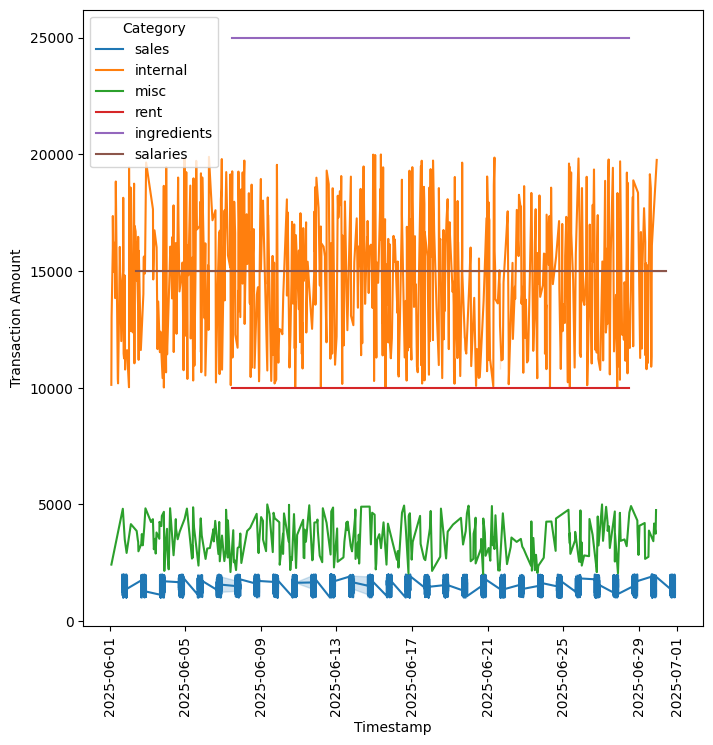

In [6]:
plt.figure(figsize=(8,8))
sns.lineplot(data=df, x='Timestamp', y='Transaction Amount', hue='Category')
plt.xticks(rotation=90)
plt.show()

The number of categories are :


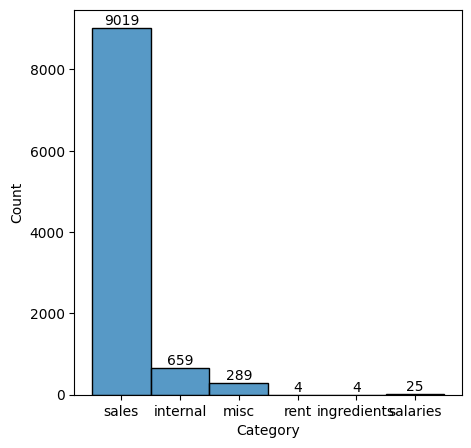

In [7]:
print('The number of categories are :')

plt.figure(figsize=(5,5))
ax = sns.histplot(data=df, x='Category')
plt.bar_label(ax.containers[0])
plt.show()

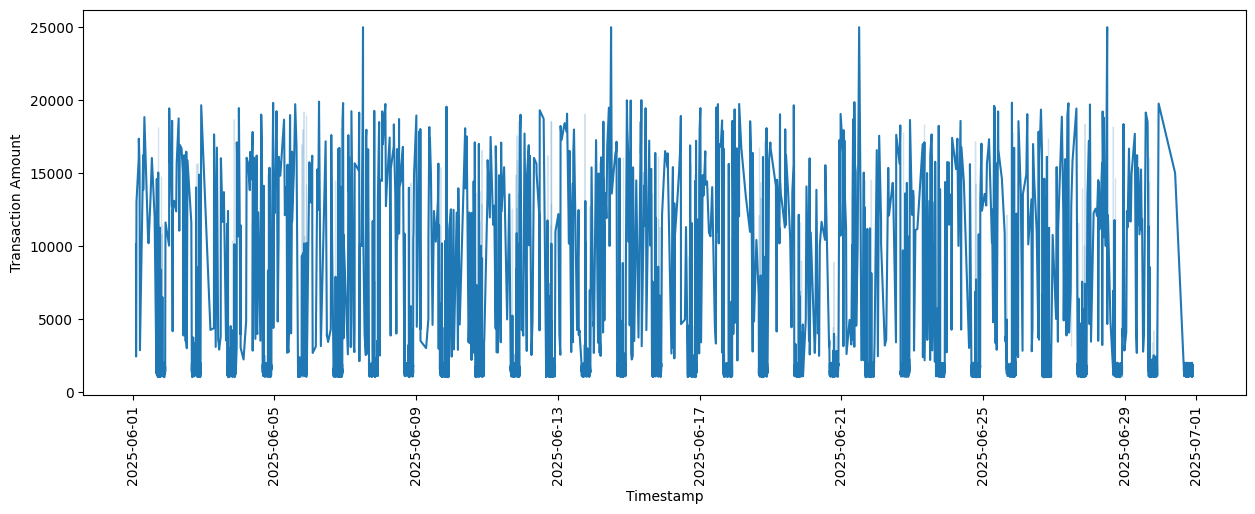

In [8]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['Timestamp'], y=df['Transaction Amount'])
plt.xticks(rotation=90)
plt.show()

## 2. Preprocessing and maybe OneHotEncoding the data

In [10]:
def preprocess(df, cafe_id):
    # Categories
    categories = list(df['Category'].value_counts().keys())
    CAFE_ID = cafe_id

    # Time values. 
    df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
    df['Day'] = pd.to_datetime(df['Timestamp']).dt.day
    df['Weekday'] = pd.to_datetime(df['Timestamp']).dt.weekday
    df = df.drop(columns=['Timestamp'])
    df = df.drop(columns=['Transaction ID'])

    # Log the amounts so the large values introduce less bias. 
    df['Transaction Amount'] = np.log(df['Transaction Amount'] + 1)

    df = pd.get_dummies(df, columns=["Transaction Type", "Device Used"], prefix=["Type", "Device"])

    # Dropping these columns because too many values
    df.drop(columns=["Sender Account ID", "Receiver Account ID"], inplace=True)

    return df, categories

In [53]:
df, categories = preprocess(df, 'ACC14994')

KeyError: 'Timestamp'

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction Amount  10000 non-null  float64
 1   Category            10000 non-null  object 
 2   Hour                10000 non-null  int32  
 3   Day                 10000 non-null  int32  
 4   Weekday             10000 non-null  int32  
 5   Type_deposit        10000 non-null  bool   
 6   Type_transfer       10000 non-null  bool   
 7   Type_withdrawal     10000 non-null  bool   
 8   Device_desktop      10000 non-null  bool   
 9   Device_mobile       10000 non-null  bool   
dtypes: bool(5), float64(1), int32(3), object(1)
memory usage: 322.4+ KB


## 3. Train test split for the data

In [60]:
from sklearn.model_selection import TimeSeriesSplit

In [62]:
X = df.drop('Category', axis=1)
y = df["Category"].astype("category").cat.codes    # 0, 1, 2, 4, 5

In [64]:
n_split = int(0.75 * len(df))
X_train = X[:n_split]
X_test = X[n_split:]
y_train = y[:n_split]
y_test = y[n_split:]

In [66]:
print('The shape of X_train, x_test : ', X_train.shape, X_test.shape)
print('The shape of y_train, y_test : ', y_train.shape, y_test.shape)
print('Length of dataset: ', len(df))

The shape of X_train, x_test :  (7500, 9) (2500, 9)
The shape of y_train, y_test :  (7500,) (2500,)
Length of dataset:  10000


In [68]:
# Okay, probably need to SMOTE this
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=2)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [70]:
print('After resampling the train data with SMOTE')
print('The shape of X_train, x_test : ', X_train.shape, X_test.shape)
print('The shape of y_train, y_test : ', y_train.shape, y_test.shape)

After resampling the train data with SMOTE
The shape of X_train, x_test :  (40560, 9) (2500, 9)
The shape of y_train, y_test :  (40560,) (2500,)


## 4. Model training

In [73]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

In [77]:
models = [
    XGBClassifier(),
    RandomForestClassifier(class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced'),
    SVC(class_weight='balanced')
]

In [79]:
for model in models:
    model.fit(X_train, y_train)

In [88]:
model_names = ['XGBoostClassifier','RandomForestClassifier','DecisionTreeClassifier','SupportVectorClassifier']

## 5. Model testing

In [82]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00        68
  

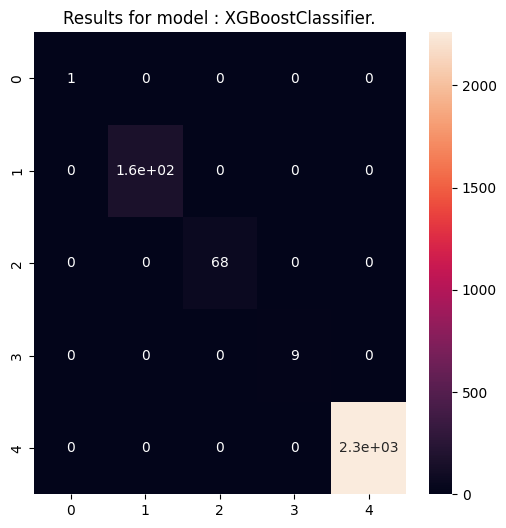

RandomForestClassifier(class_weight='balanced')
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00        68
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00      2259

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



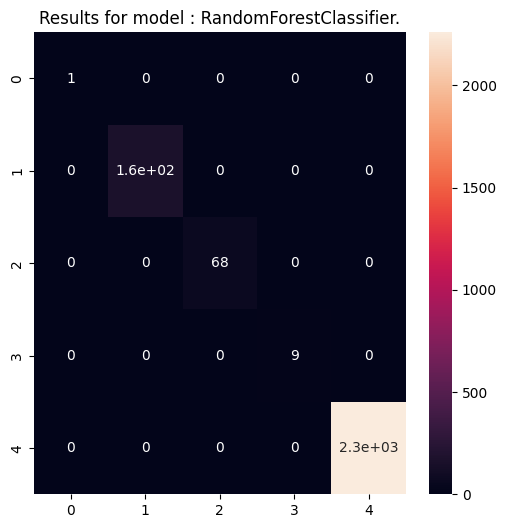

DecisionTreeClassifier(class_weight='balanced')
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00        68
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00      2259

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



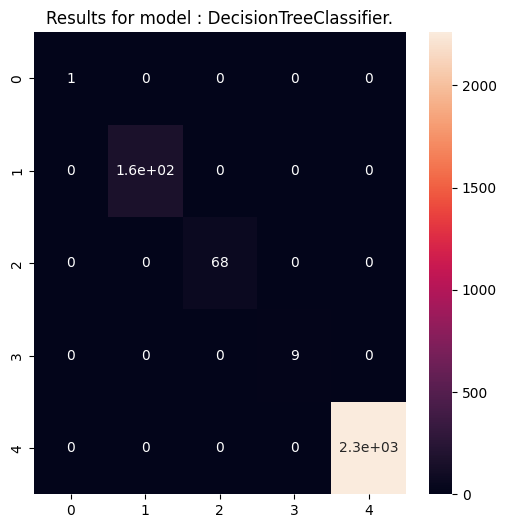

SVC(class_weight='balanced')
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00        68
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00      2259

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



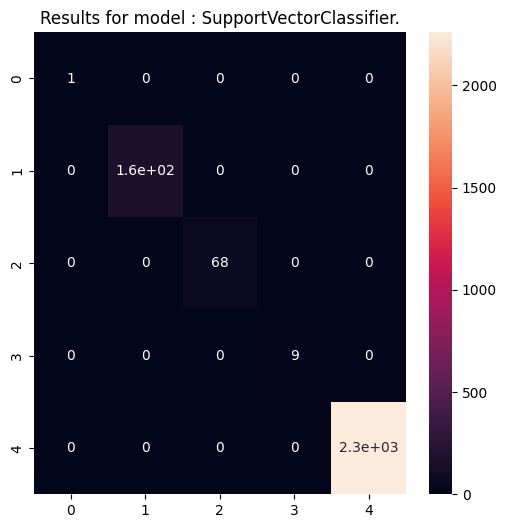

In [92]:
for name, model in zip(model_names, models):
    print(model)
    y_pred = model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0.0))

    conf = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,6))
    plt.title(f"Results for model : {name}.")
    sns.heatmap(conf, annot=True)

    plt.savefig(f"{name}_results.png", dpi=400, bbox_inches='tight')
    plt.show()